# Ev analysis of plrnn


In [1]:
using Revise

using BPTT
using Flux
using NPZ
using LinearAlgebra
using BSON: @load


In [2]:
function gen_path(exp::String, name::String, run::Int, epoch::Int; eval=true)::BPTT.AbstractPLRNN
    load_path = joinpath(["Results", exp, name, format_run_ID(run)])
    if eval
        load_path = "../" * load_path
    end
    return joinpath(load_path, "checkpoints", "model_$epoch.bson")
end
function format_run_ID(run::Int)::String
    run_str = string(run)
    n_digits = length(run_str)
    @assert n_digits < 4
    add_zeros = 3 - n_digits
    return repeat("0", add_zeros) * run_str
end
function load_result_path(exp::String, epoch, run ;eval=true)
    run = format_run_ID(run)
    path = "Results/" * exp * "/evd/$run/checkpoints/" * "model_$epoch.bson"
    if eval
        path = "../"*path
    end
    return path
end


load_result_path (generic function with 1 method)

In [3]:

model_path = gen_path("default", "test", 1, 50)
m = load_model(model_path)

# compose single matrix AW
AW = diagm(m.A) + m.W;

# get evd of AW
EVD = eigen(AW);
λs = EVD.values;
V = EVD.vectors;


MethodError: MethodError: Cannot `convert` an object of type String to an object of type BPTT.AbstractPLRNN
Closest candidates are:
  convert(::Type{T}, !Matched::T) where T at /opt/julia-1.7.3/share/julia/base/essentials.jl:218

In [4]:
using Plots
scatter(imag(λs), label="imaginary")
scatter!(real(λs), label="real")

UndefVarError: UndefVarError: λs not defined

In [5]:
scatter(abs2.(λs))

UndefVarError: UndefVarError: λs not defined

# ev analasis for all models

In [6]:
# exp = lorenz_20...
# probably need to do it  by hand for bursting neuron
function remove!(a, item)
    deleteat!(a, findall(x -> x == item, a))
end

experiments = readdir("../Results")
remove!(experiments, "default")
deleteat!(experiments, findall(x->occursin("bursting",x),experiments))


3-element Vector{String}:
 "lorenz_20"
 "lorenz_22"
 "lorenz_24"

In [7]:
using BPTT
using Plots
# load all the experiments
for exp in experiments
    model_path = load_result_path(exp, 1000,1)
    m = BPTT.load_model(model_path)

    # compose single matrix AW
    AW = diagm(m.A) + m.W

    # get evd of AW
    EVD = eigen(AW)
    λs = EVD.values
    Vs = EVD.vectors
    try
        push!(exp_λs, λs)
        push!(exp_Vs, Vs)
    catch e
        global exp_λs = [λs]
        global exp_Vs = [Vs]
    end
end

# for making subplots for each experiment
function make_subplots(exp, plots, type)
    if exp == "lorenz"
        μ = "ρ"
        title = ["\n20" "ρ as bifurcation parameter\n22" "\n24" "\n25" "\n28" "\n34"]
    else
        μ = "\$g_{nmda}\$"
        title = ["\n2" "$μ as bifurcation parameter\n3" "\n5" "\n9" "\n10" "\n10.2"]
    end
    p = plot(plots..., layout=grid(1,6),
        title=title, titlefont=font(11),
        legend=nothing,
        plot_title="$type of evd with $exp plrnn", plot_titlevspan=0.08
    )
    display(p)
end


make_subplots (generic function with 1 method)

In [8]:
# convert to array
arr_exp_l = reduce(hcat, exp_λs)
size(arr_exp_l)

(15, 3)

In [9]:
# Plots of single experiments

# sort the absolute values for comparison
abs_λ = [sort(abs.(lambdas)) for lambdas in exp_λs]

# histogram of all abs values
hists_abs_val = (histogram(abs_val, bins=8) for abs_val in abs_λ)

# im and real part in one figure
for lambdas in exp_λs
    imre = scatter(imag(lambdas),label="imag")
    scatter!(imre, real(lambdas),label="real")
    try
        push!(im_res, imre)
    catch
        global im_res = [imre]
    end
end


Base.Generator{Vector{Vector{Float32}}, var"#21#22"}(var"#21#22"(), Vector{Float32}[[0.062021613, 0.18844248, 0.22967681, 0.2843479, 0.32507196, 0.54415613, 0.54415613, 0.5474001, 0.5474001, 0.66958696, 0.7459723, 1.1800116, 1.2586954, 1.2586954, 1.3574357], [0.15652315, 0.20890692, 0.20890692, 0.21899417, 0.2384606, 0.2384606, 0.43744597, 0.4632393, 0.5842352, 0.6446682, 0.6446682, 0.72890645, 1.0640448, 1.2615663, 1.5072728], [0.008065852, 0.103529945, 0.121448115, 0.3430135, 0.38485283, 0.38485283, 0.54021406, 0.54021406, 0.5497001, 0.5497001, 0.72259504, 0.72259504, 0.8852963, 1.063199, 1.3253585]])

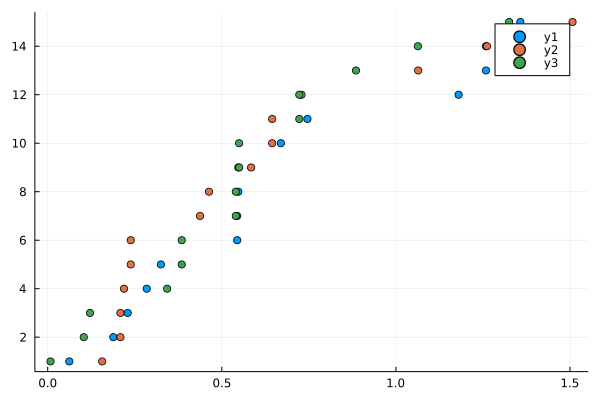

In [25]:
# abs values together
for abs_val in abs_λ
    try
        scatter!(abss, abs_val, 1:15)
    catch
        global abss = scatter(abs_val, 1:15)
    end
end
display(abss)


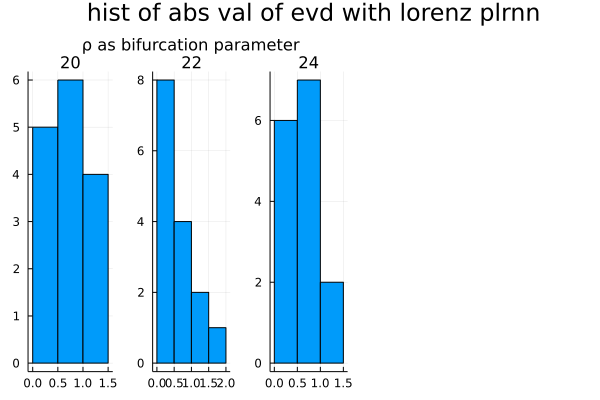

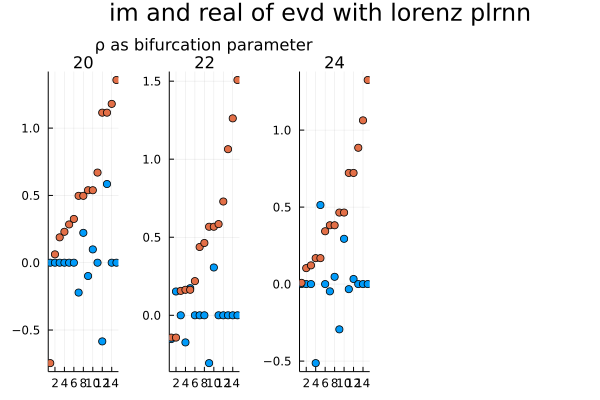

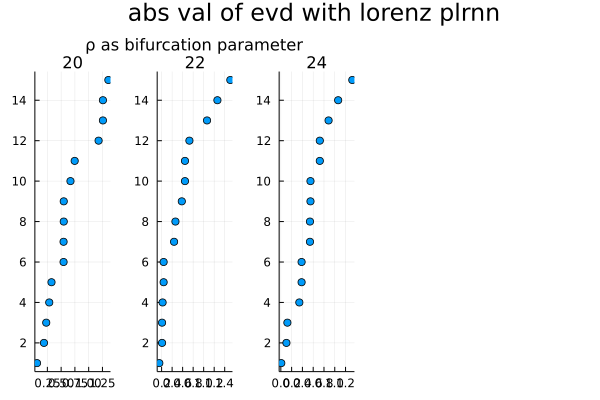

In [23]:
make_subplots("lorenz", hists_abs_val, "hist of abs val")
make_subplots("lorenz", im_res,"im and real")


In [12]:
# look at change of the parameters
for id in 2:3#6 # for all experiments
    try
        push!(change_abs, abs_λ[id]./abs_λ[id-1])
    catch e
        global change_abs = [abs_λ[id]./abs_λ[id-1]]
    end
end
arr_change_abs = reduce(hcat, change_abs);


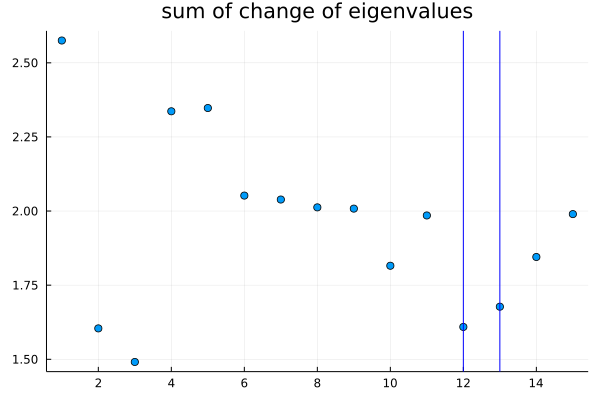

In [13]:
# hist of overall change in eigenvalues
hist_abs = histogram(collect(Iterators.flatten(change_abs).-1), title="change of all eigenvalues", legend=nothing,bins=15)

# hist of change of the values itselfs
hist_lambda_abs = scatter(sum(arr_change_abs,dims=2),title="sum of change of eigenvalues",legend=nothing)
vline!(hist_lambda_abs,[12,13], c=:blue, linewidth=1)


In [14]:
# plot the change of some of the imoprtant eigenvalues
val, idx = findmax(sum(arr_change_abs, dims=2))
arr_abs_λ = reduce(hcat, abs_λ)


15×3 Matrix{Float32}:
 0.0620216  0.156523  0.00806585
 0.188442   0.208907  0.10353
 0.229677   0.208907  0.121448
 0.284348   0.218994  0.343013
 0.325072   0.238461  0.384853
 0.544156   0.238461  0.384853
 0.544156   0.437446  0.540214
 0.5474     0.463239  0.540214
 0.5474     0.584235  0.5497
 0.669587   0.644668  0.5497
 0.745972   0.644668  0.722595
 1.18001    0.728906  0.722595
 1.2587     1.06404   0.885296
 1.2587     1.26157   1.0632
 1.35744    1.50727   1.32536

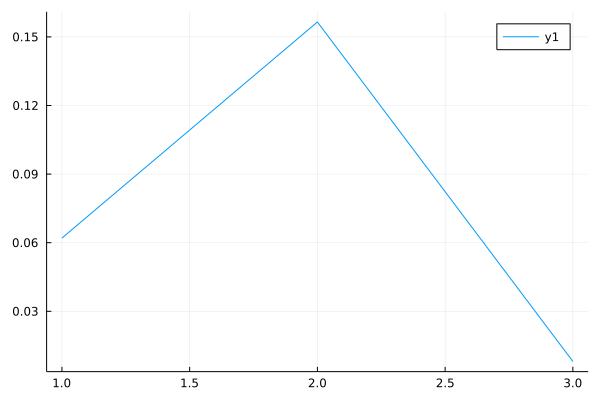

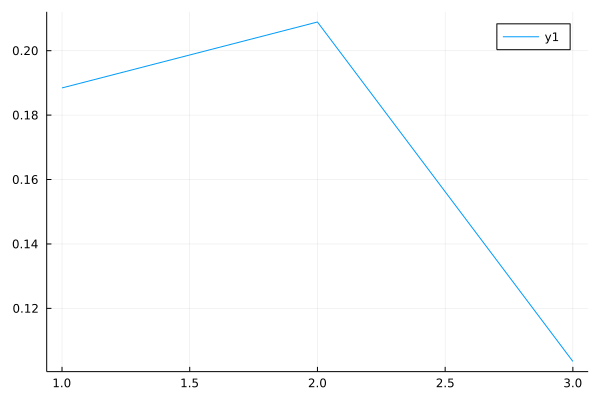

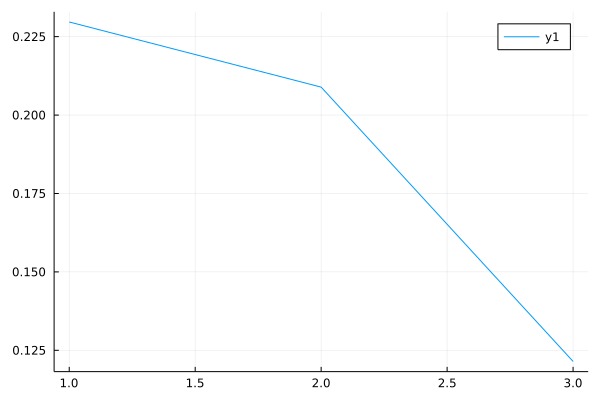

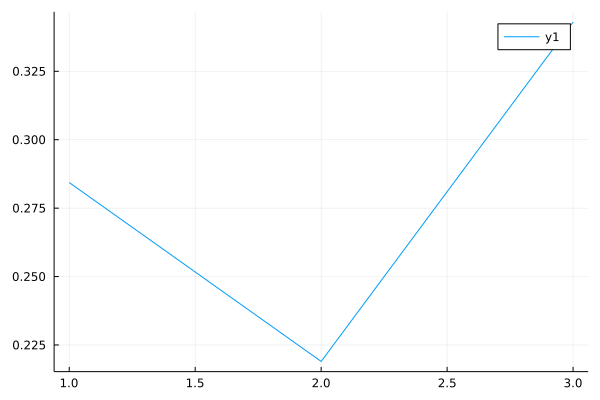

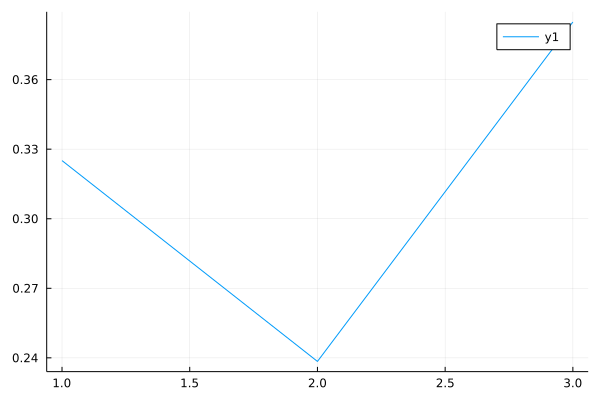

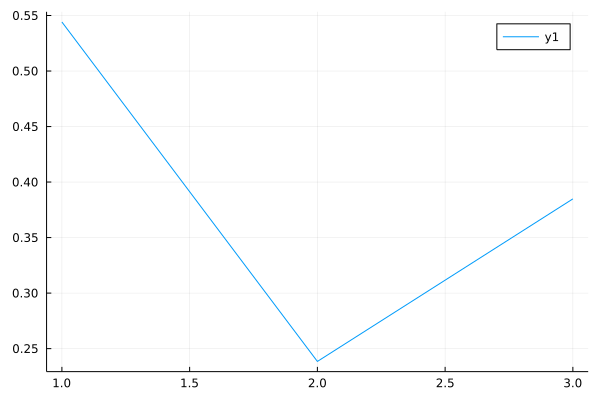

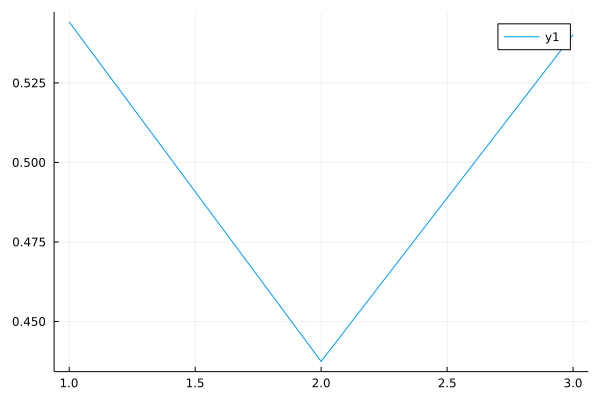

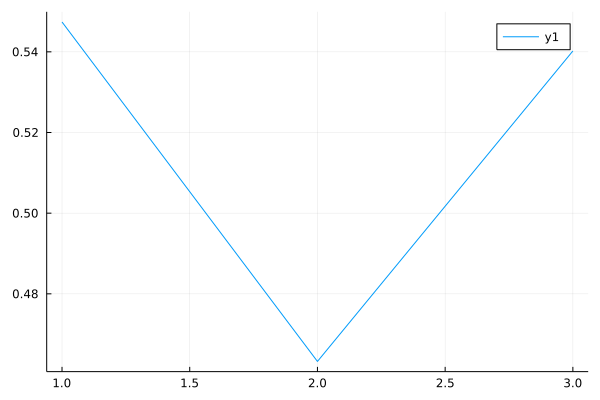

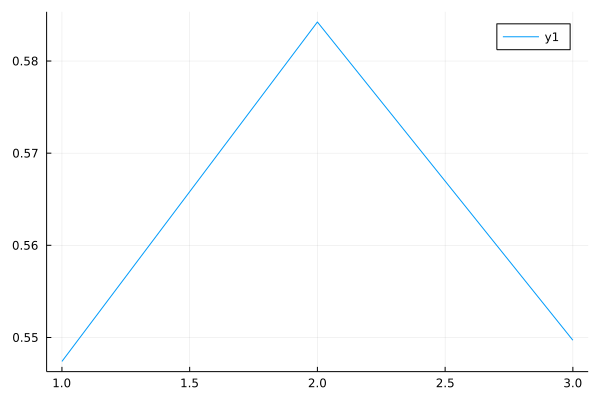

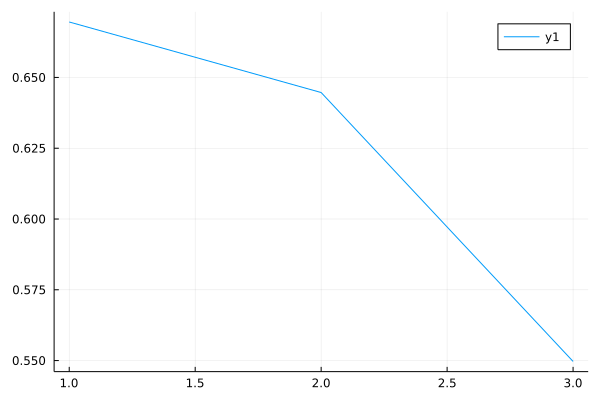

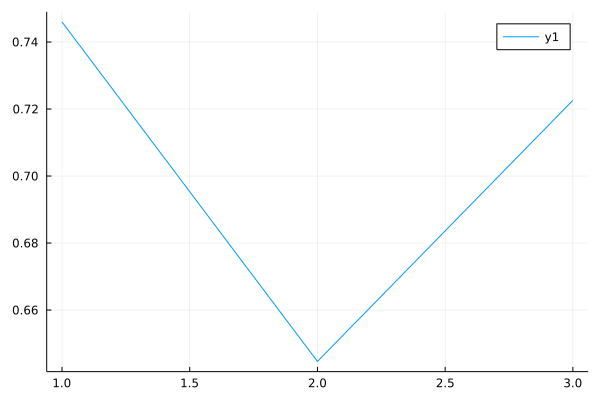

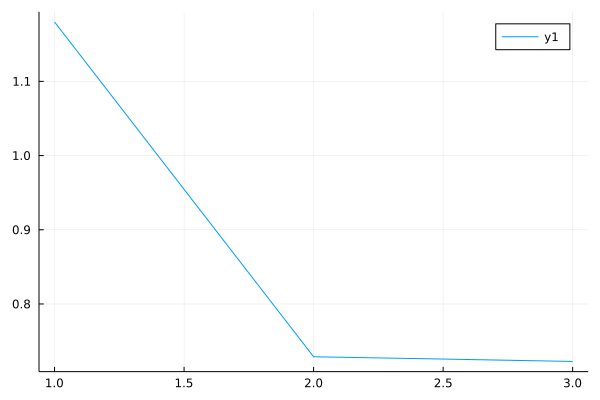

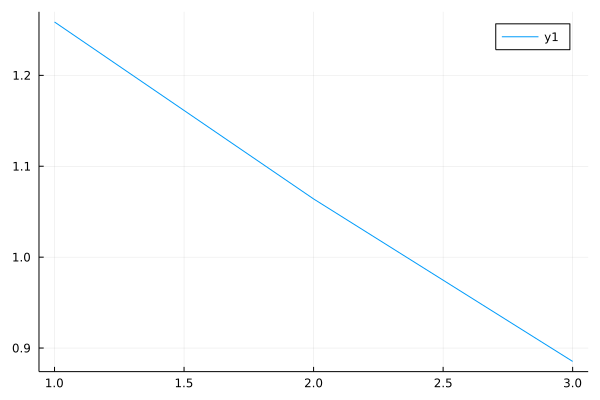

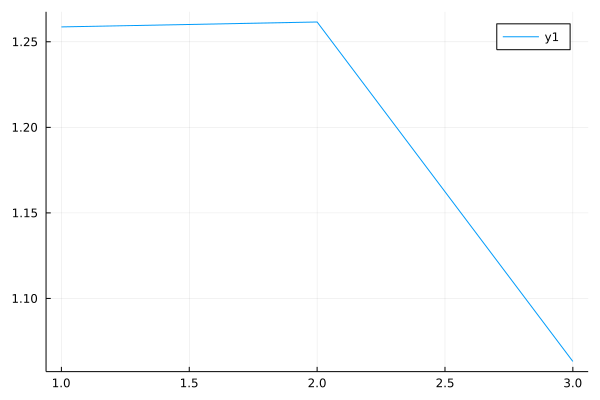

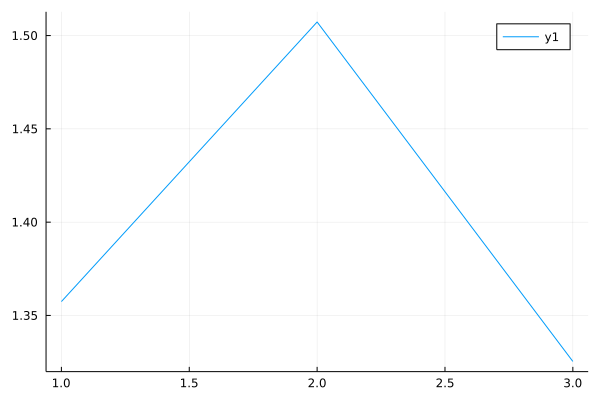

In [31]:
for i in 1:15 # lorenz
    p = plot(arr_abs_λ[i,:])
    # display(p);
end

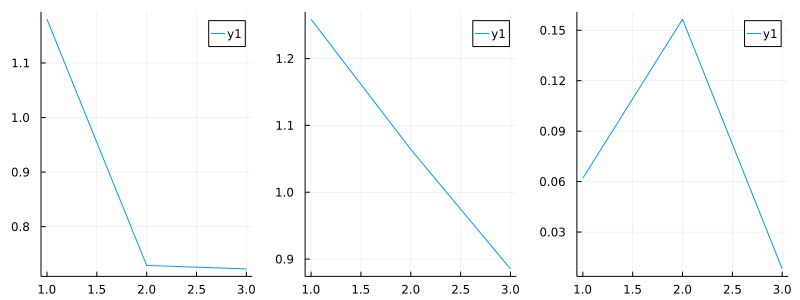

In [15]:
# specific plot, to show different changes
a=plot(arr_abs_λ[12,:])
b=plot(arr_abs_λ[13,:])
c=plot(arr_abs_λ[idx[2],:])
plot(a,b,c, layout=grid(1,3), size=(800,300))

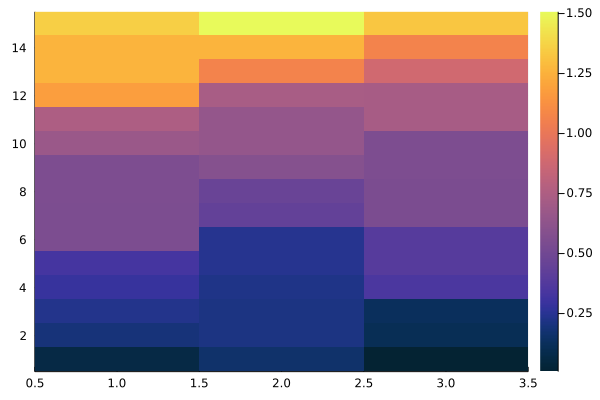

In [29]:
# heatmap for all eigenvalues
heatmap(abs.(arr_abs_λ), c=:thermal)